<h4>Librerie Necessarie:</h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

<h4>Lettura del DataFrame:</h4>

In [2]:
df = pd.read_csv("../data/star_classification.csv")

In [3]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

<h4>Come possiamo notare, non abbiamo valori nulli. Ottimo per poterci alleggerire la fase di pulizia dei dati</h4>

In [5]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


<h3>1. PULIZIA DEI DATI</h3>

<h4>Rinominazione delle colonne: u, g, r, i, z, al fine di garantire maggiore chiarezza dei dati</h4>

In [6]:
df.rename(columns={
    "u": "ultraviolet",
    "g": "green",
    "r": "red",
    "i": "near_infrared",
    "z": "infrared"
}, inplace=True) # con il valore andiamo ad indicare di andare a modificare il dataframe originale, senza creare una copia

<p>Spiegazione colonne DataFrame: </p>
<ul>
    <li>Alpha e delta: posizione dell'oggetto nel cielo</li>
    <li>U, g, r, i, z: spettro di luce che emana l'oggetto</li>
    <li>Class: classificazione dell'oggetto</li>
    <li>Redshift: misura quanto la luce di un oggetto è spostato verso il rosso rispetto a come viene emessa</li>
    <li>Plate: tipo di fibra usato nell'obbiettivo</li>
    <li>MJD: data in cui è stata scattata la foto, basandosi sul calendario Giuliano modificato</li>
</ul>

<h4>Eliminazione colonne superflue per l'esplorazione dei dati</h4>

In [7]:
uselessColumns = ['run_ID', 'rerun_ID', 'cam_col', 'fiber_ID', 'field_ID']
df = df.drop(uselessColumns, axis=1)

print(f"Sono state cancellate le seguenti colonne: {uselessColumns}")

Sono state cancellate le seguenti colonne: ['run_ID', 'rerun_ID', 'cam_col', 'fiber_ID', 'field_ID']


<h4>Eliminazione righe dove contengono valori sentinella. Essi sbilanciano di molto analisi future, meglio rimuoverle</h4>

In [8]:
df = df[
    (df["ultraviolet"] > -1000) &
    (df["green"] > -1000) &
    (df["infrared"] > -1000)
]

In [9]:
df.describe()

,obj_ID,alpha,delta,ultraviolet,green,red,near_infrared,infrared,spec_obj_ID,redshift,plate,MJD
count,9.999900e+04,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,9.999900e+04,99999.000000,99999.000000,99999.000000
mean,1.237665e+18,177.628653,24.135552,22.080679,20.631583,19.645777,19.084865,18.768988,5.783903e+18,0.576667,5137.027890,55588.653687
std,8.438450e+12,96.502612,19.644608,2.251068,2.037384,1.854763,1.757900,1.765982,3.324026e+18,0.730709,2952.312485,1808.492217
min,1.237646e+18,0.005528,-18.785328,10.996230,10.498200,9.822070,9.469903,9.612333,2.995191e+17,-0.009971,266.000000,51608.000000
25%,1.237659e+18,127.517698,5.147477,20.352410,18.965240,18.135795,17.732280,17.460830,2.844137e+18,0.054522,2526.000000,54234.000000
50%,1.237663e+18,180.900527,23.646462,22.179140,21.099930,20.125310,19.405150,19.004600,5.614896e+18,0.424176,4987.000000,55869.000000
75%,1.237668e+18,233.895005,39.901582,23.687480,22.123775,21.044790,20.396510,19.921120,8.332365e+18,0.704172,7400.500000,56777.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,1.412694e+19,7.011245,12547.000000,58932.000000


<h3>2. Analisi Esplorativa Dei Dati</h3>

<h4>a. Contiamo le ricorrenze della colonna target "class"</h4>

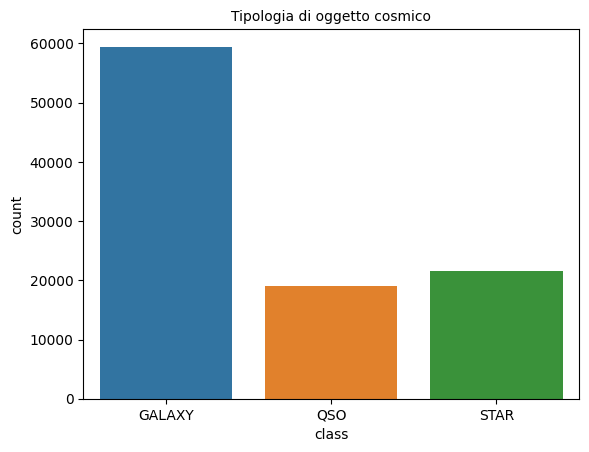

In [10]:
sns.countplot(data=df, x="class", hue="class")
plt.title("Tipologia di oggetto cosmico",fontsize=10)
plt.show()

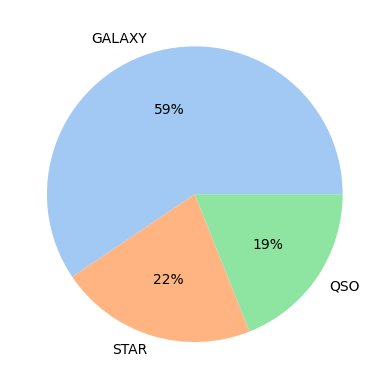

class
GALAXY    59445
STAR      21593
QSO       18961
Name: count, dtype: int64

In [11]:
data = df["class"].value_counts()
labels = ['GALAXY', 'STAR', 'QSO']
# define Seaborn color palette to use
colors = sns.color_palette('pastel')

# plotting data on chart
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()
data

<h5>Possiamo notare come la classe prioritaria "GALAXY" sia circa il 60% dei dati complessivi, rispetto alle altre due minoritarie molto simili, "START" e "QSO", che si attestano intorno al 20%. Il DataSet non presenta un forte sbilanciamento.</h5>

<h4>b. Stampiamo la HEATMAP per verificare la correlazione delle variabili</h4>

<h5>Applichiamo una funzione encoder sulle colonne non numeriche</h5>

In [12]:
def encode_class(value):
    if value == "GALAXY":
        return 0
    elif value == "STAR":
        return 1
    else:
        return 2
    
df_encoded = df.copy()
df_encoded["class"] = df_encoded["class"].apply(encode_class)

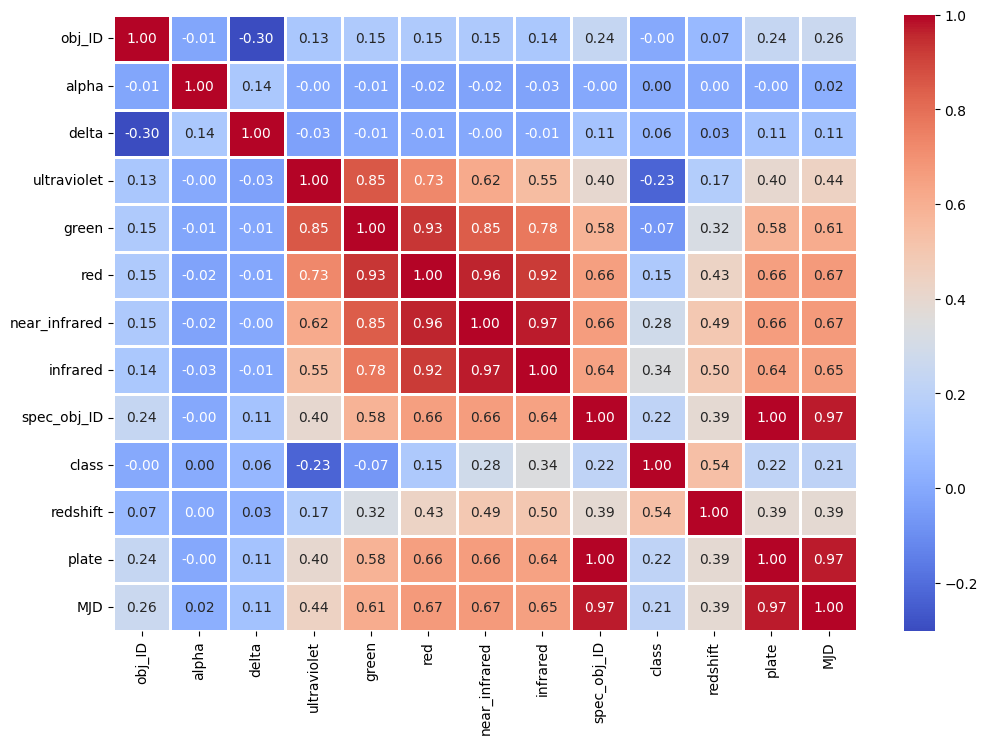

In [13]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", annot=True, linewidths=1, fmt= '.2f',ax=ax)
plt.show()

<h4>c. Relazione tra bande fotometrice tramite scatterplot</h4>

In [14]:
# sns.pairplot(
#     df[["ultraviolet", "green", "red", "near_infrared", "infrared", "class"]],
#     hue="class",
#     diag_kind="hist",
#     plot_kws={"alpha": 0.5, "s": 20}
# )

# plt.show()


<h5>Si può notare come, in alcuni scatterplot, non si riesca a differenziare bene la differenza di classe, sovrapponendosi.</h5>

<h5>Quelli che sembrano dividere meglio sono: </h5>

<ul>
    <li>Red and Near_infrared</li>
    <li>ultraviolet and infrared, differenza tra STAR e GALAXY ma non buona per QSO</li>
    <li>Green and Near_infrared, uguale per i QSO</li>
</ul>

<h4>d. Istogramma bande magnitudinali</h4>

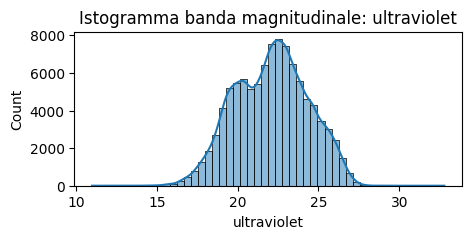

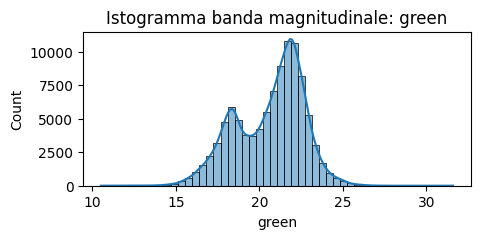

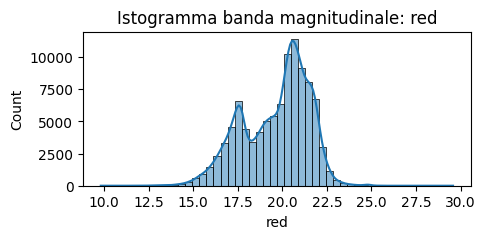

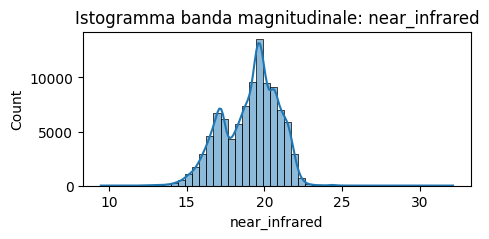

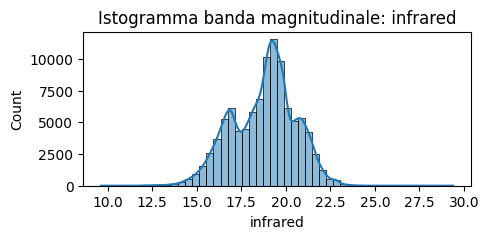

In [15]:
data = df[["ultraviolet", "green", "red", "near_infrared", "infrared"]].copy()



for d in data.columns:
    plt.figure(figsize=(5, 2))
    sns.histplot(x=data[d], kde=True, bins=50)
    plt.title(f"Istogramma banda magnitudinale: {d}")
    plt.show()

<h4>d. Mostriamo come, tramite scatterplot, la luminosità degli oggetti stellari cambia in relazione alla loro distanza</h4>

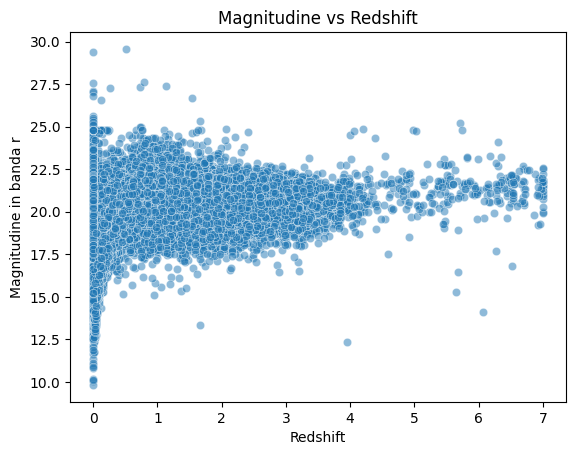

In [16]:
sns.scatterplot(data=df, x="redshift", y="red", alpha=0.5)
plt.xlabel("Redshift")
plt.ylabel("Magnitudine in banda r")
plt.title("Magnitudine vs Redshift")
plt.show()


<h4>e. Classificazione oggetti stellari tramite le loro bande</h4>
<h5>Ogni stella, viene categorizzata in valori tramite</h5>

In [17]:
stars = df[df["class"] == "STAR"].copy()

In [18]:
stars["u_g"] = stars["ultraviolet"] - stars["green"]
stars["g_r"] = stars["green"] - stars["red"]
stars["r_i"] = stars["red"] - stars["near_infrared"]
stars["i_z"] = stars["near_infrared"] - stars["infrared"]

In [19]:
def spectral_type_from_gr(g_r):
    if g_r < -0.2:
        return "O/B"
    elif g_r < 0.0:
        return "A"
    elif g_r < 0.3:
        return "F"
    elif g_r < 0.6:
        return "G"
    elif g_r < 1.0:
        return "K"
    else:
        return "M"
    
stars["spectral_type"] = stars["g_r"].apply(spectral_type_from_gr)

In [20]:
stars[["obj_ID", "alpha", "delta", "ultraviolet", "green", "red", "g_r", "spectral_type"]].head()

,obj_ID,alpha,delta,ultraviolet,green,red,g_r,spectral_type
9,1.237671e+18,39.149691,28.102842,21.74669,20.03493,19.17553,0.85940,K
12,1.237681e+18,345.801874,32.672868,23.17274,20.14496,19.41948,0.72548,K
16,1.237679e+18,353.201522,3.080796,24.54890,21.44267,20.95315,0.48952,G
18,1.237679e+18,14.383135,3.214326,21.82154,20.55730,19.94918,0.60812,K
21,1.237658e+18,144.785293,46.826496,24.54793,22.33601,20.92259,1.41342,M


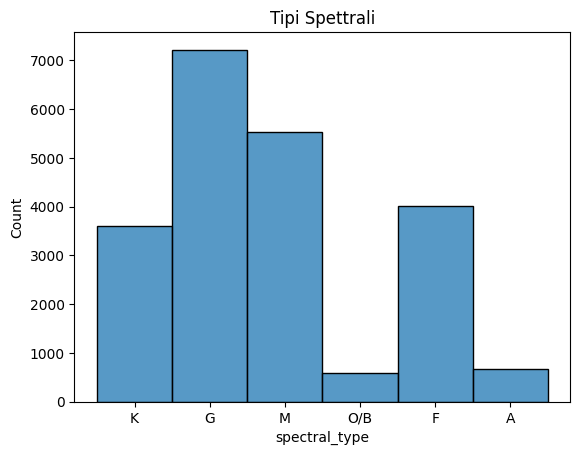

In [21]:
sns.histplot(x=stars["spectral_type"])
plt.title("Tipi Spettrali")
plt.show()

<h5>La maggior parte di stelle all'interno del nostro DATASET hanno classe spettrale G, simili al nostro sole!</h5>
<h5>La temperatura si aggira circa tra i 5.300 k e i 6.000 k</h5>

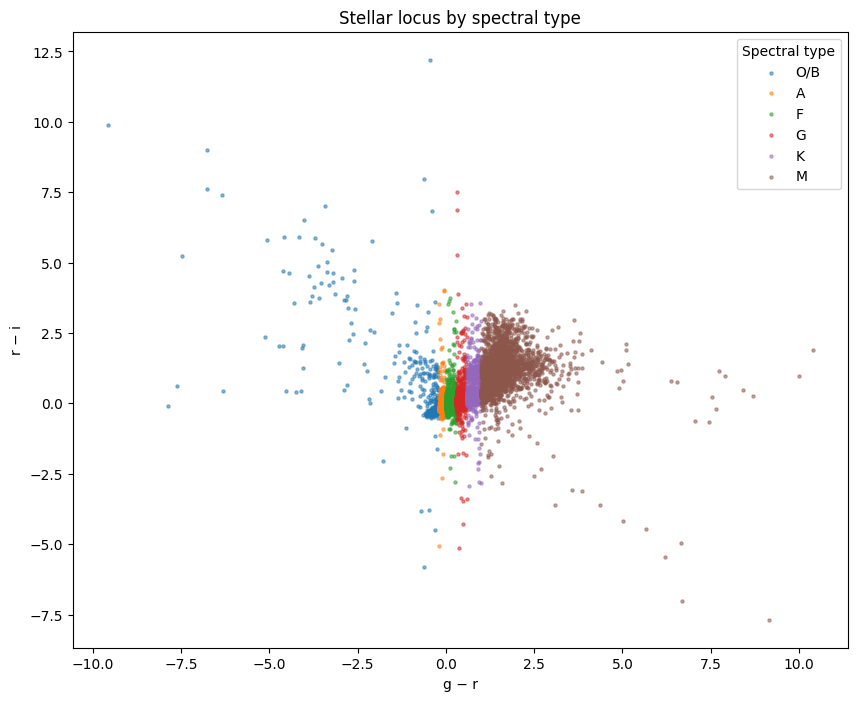

In [22]:
plt.figure(figsize=(10,8))

for t in ["O/B", "A", "F", "G", "K", "M"]:
    sub = stars[stars["spectral_type"] == t]
    plt.scatter(sub["g_r"], sub["r_i"], s=5, alpha=0.5, label=t)

plt.xlabel("g − r")
plt.ylabel("r − i")
plt.title("Stellar locus by spectral type")
plt.legend(title="Spectral type")
plt.show()

<em>log<sub>10</sub>(T<sub>eff</sub>) = 3.877 − 0.26(g−r)</em>

In [23]:
stars = stars[stars["g_r"].between(-0.3, 1.0)]

In [24]:
stars["Teff_K"] = 10 ** (3.877 - 0.26 * stars["g_r"])

In [25]:
stars["Teff_K"].describe()

count    15673.000000
mean      5929.836756
std        906.912529
min       4140.046319
25%       5312.931297
50%       5930.850816
75%       6403.007345
max       9014.092285
Name: Teff_K, dtype: float64

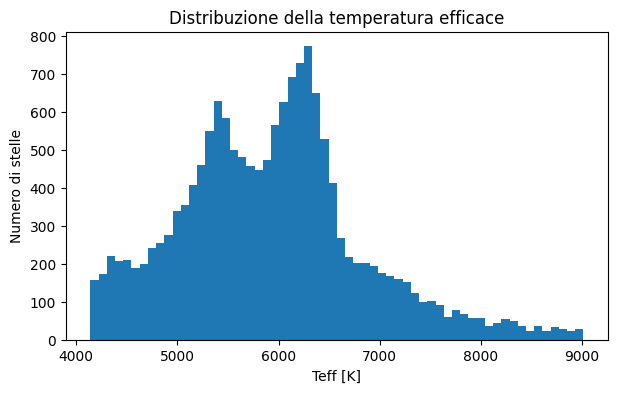

In [26]:
plt.figure(figsize=(7,4))
plt.hist(stars["Teff_K"], bins=60)
plt.xlabel("Teff [K]")
plt.ylabel("Numero di stelle")
plt.title("Distribuzione della temperatura efficace")
plt.show()

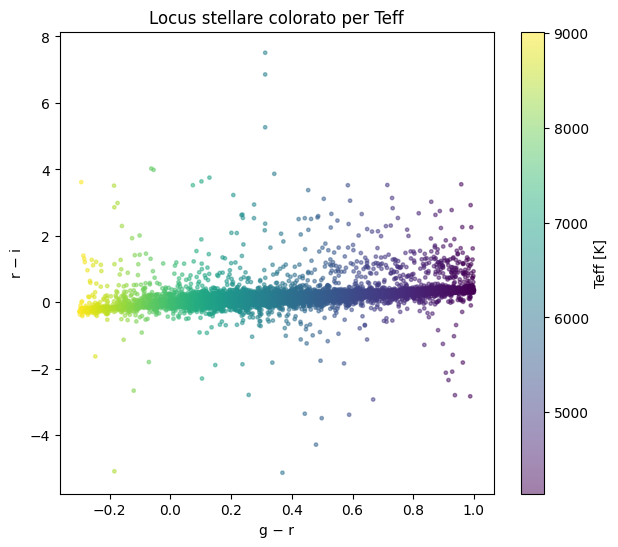

In [27]:
stars["r_i"] = stars["red"] - stars["near_infrared"]

plt.figure(figsize=(7,6))
sc = plt.scatter(
    stars["g_r"],
    stars["r_i"],
    c=stars["Teff_K"],
    s=6,
    alpha=0.5
)
plt.xlabel("g − r")
plt.ylabel("r − i")
plt.title("Locus stellare colorato per Teff")
plt.colorbar(sc, label="Teff [K]")
plt.show()

<h4>Da mdefinirei</h4>


In [28]:
plt.colorbar(sc, label="Teff [K]")

C:\Users\manue\AppData\Local\Temp\ipykernel_32428\525585779.py:1: UserWarning: Adding colorbar to a different Figure <Figure size 700x600 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, label="Teff [K]")


<Figure size 640x480 with 0 Axes>